In [1]:
import tomllib
from pathlib import Path

import hvplot.polars  # noqa
import polars as pl

hvplot.extension("matplotlib")


In [2]:
config_filepath = "../../pipeline_config.toml"
with open(config_filepath, "rb") as f:
    config = tomllib.load(f)

In [3]:
hh = pl.read_csv(Path(config["raw"]["dir"]) / config["hh_filename"])
person = pl.read_csv(Path(config["raw"]["dir"]) / config["person_filename"])
trip = pl.read_csv(Path(config["raw"]["dir"]) / config["trip_filename"])
day = pl.read_csv(Path(config["raw"]["dir"]) / config["day_filename"]).with_columns(
    pl.col("hh_day_complete").cast(bool)
)
personday = day.join(person, on="person_id")
tripday = trip.join(day, on="day_id")

In [4]:
# the day weight is the person-day weight, except that the person-day weight = 0 for
# incomplete hh days (i.e. only days where the entire hh is complete is counted, even
# if a person has a complete set of trips on that day---this can be seen most clearly in
# the case of proxy reporting for kids: only the day of proxy reporting for the kids
# has non-zero weights for the adults, even if the adults are on rMove the entire week)

In [5]:
print(
    "From here on, I refer to the day weights as (person-)day weights, "
    "because that's what they are."
)


From here on, I refer to the day weights as (person-)day weights, because that's what they are.


In [6]:
print(
    "For each person, if we only count Tue/Wed/Thu days that are complete for the "
    "entire hh, \nthe (person-)day weight is nonzero and unique"
)
day.filter(pl.col("travel_dow").is_in([2, 3, 4]) & pl.col("hh_day_complete")).group_by(
    "person_id"
).agg(pl.col("day_weight").unique()).select(
    day_weight_is_unique=(pl.col("day_weight").list.len() == 1).all(),
    day_weight_gt_zero=(pl.col("day_weight").list.first() > 0).all(),
)


For each person, if we only count Tue/Wed/Thu days that are complete for the entire hh, the (person-)day weight is nonzero and unique


day_weight_is_unique,day_weight_gt_zero
bool,bool
true,true


In [7]:
print("(person-)day weights behave as expected:")
print(
    "For each person-day, (person-)day weight = person weight / "
    "(number of Tue/Wed/Thu days that are complete for the entire hh)"
)
# need to round because float comparisons are inexact,
# and isclose isn't implemented in polars
personday.filter(
    pl.col("travel_dow").is_in([2, 3, 4]) & pl.col("hh_day_complete")
).group_by("person_id").agg(
    pl.len(),
    pl.col("person_weight").unique().first(),
    pl.col("day_weight").unique().first(),
).select(
    (
        (pl.col("person_weight") / pl.col("len")).round(6)
        == pl.col("day_weight").round(6)
    ).all()
)

(person-)day weights behave as expected:
For each person-day, (person-)day weight = person weight / (number of Tue/Wed/Thu days that are complete for the entire hh)


person_weight
bool
true


In [8]:
print("(trip_weight == 0) iff (day_weight == 0):")
print(
    tripday.filter(pl.col("trip_weight") == 0)
    .select((pl.col("day_weight") == 0).all())
    .item(),
    tripday.filter(pl.col("day_weight") == 0)
    .select((pl.col("trip_weight") == 0).all())
    .item(),
)

(trip_weight == 0) iff (day_weight == 0):
True True


In [9]:
print(
    "all rMove trips have trip_weight == day_weight:",
    (
        tripday.filter(pl.col("trip_weight_rmove_only") > 0)  # only look at rMove trips
        .select((pl.col("trip_weight") == pl.col("day_weight")).all())
        .item()
    ),
)


all rMove trips have trip_weight == day_weight: True


all non-rMove trips have trip_weight = day_weight * (trip factor between 1.0 and 2.0000000000000093)


:Histogram   [trip_weight]   (Count)
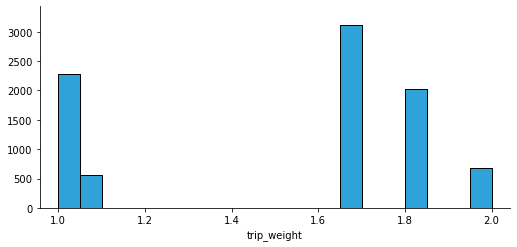

In [10]:
non_rmove_trips_with_nonzero_weight_trip_weight_day_weight_ratio = (
    tripday
    # only look at non-rMove trips with day_weight > 0
    .filter(
        (pl.col("trip_weight_rmove_only") == 0) & (pl.col("day_weight") > 0)
    ).select((pl.col("trip_weight") / pl.col("day_weight")))
)
print(
    "all non-rMove trips have:
    "trip_weight = day_weight * (trip factor between "
    f"{non_rmove_trips_with_nonzero_weight_trip_weight_day_weight_ratio.min().item()} "
    "and "
    f"{non_rmove_trips_with_nonzero_weight_trip_weight_day_weight_ratio.max().item()})"
)
non_rmove_trips_with_nonzero_weight_trip_weight_day_weight_ratio.plot.hist()

In [11]:
print(
    "the day_weight sum would be the number of trips "
    "WITHOUT the trip factor adjustment for non-rMove trips"
)
print(
    "the trip_weight sum is the number of trips "
    "WITH the trip factor adjustment for non-rMove trips"
)
trip.join(day, on="day_id").select(
    pl.sum(
        "trip_weight", "trip_weight_rmove_only", "day_weight", "day_weight_rmove_only"
    )
)


the day_weight sum would be the number of trips WITHOUT the trip factor adjustment for non-rMove trips
the trip_weight sum is the number of trips WITH the trip factor adjustment for non-rMove trips


trip_weight,trip_weight_rmove_only,day_weight,day_weight_rmove_only
f64,f64,f64,f64
2.5426e7,2.5208e7,2.3775e7,2.5208e7
